# Linear Regression

Today we will start working on our first Machine Learning model: Linear Regression.

# TODO:
- change variables for non-challenge predictor
- extend evaluation sections
- add 3D visualization for multivariate regression
- make sure we're just using one regression function consistently
- maybe implement it by hand first? To show how least squares works? May be too much

# Table of contents
[1. Linear Regression](#3.-Linear-Regression)
- evaluation

[2. Multivariate-Regression](#4.-Multivariate-Regression)
- evaluation


# Linear Regression

Linear regression is a linear approach to modelling the relationship between a continuous variable (called the outcome or the dependent variable) and one explanatory variable (called predictor or independent variable). 

In linear regression, we plot the data on a scatter plot and then compute the best-fit line through the data points. The term "best-fit" refers to the fact that the resulting line minimizes the squared distance between the data points and the line. 

The best-fit line is described by the equation:

$$Y = c_0 + c_1 X + \epsilon$$

where $c_0$ is the regression coefficient associated with the value of $Y$ when $X=0$, $c_1$ is the regression coefficient that tells us by how much $Y$ changes when $X$ is not zero, and $\epsilon$ is noise. For now, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise. The resulting equation $Y = c_0 + c_1 X$ is just the equation for a line with $c_0$ as its y-intercept and $c_1$ is its slope. 

The best-fit line provides what is known as a linear model which allows us to make predictions about the value of $Y$ given the value of $X$.

In this section we will build a linear regression model to predict the child's GPA scores. As a predictor, we will use language and literacy skills (feature `t5c13a`), science and social skills (feature `t5c13b`), and math skills (feature `t5c13c`).

Now we have two data sets. The first data set, called data_frame contains the cleaned data which we will use to infer/predict the data in the second data set called outcome. 

**Observe that the challengeID reflects which rows remain in the outcome DataFrame after NaN removal.**

In [1]:
# First, we import the libraries we will use in this notebook and load the Fragile Families data. 
# The first line sets maplotlib plots to show inside the notebook.
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import ff

In [2]:
# Read in data
background = "../../ai4all_data/background.csv"
train = "../../ai4all_data/train.csv"

# Read in data
data_frame = pd.read_csv(background, low_memory=False)
data_frame = data_frame.set_index('challengeID')

# outcome variables
outcome = pd.read_csv(train, low_memory=False)
outcome = outcome.set_index('challengeID')

In [4]:
train_X = data_frame.loc[outcome.index]

Pick out the students' language and literacy skills (`t5c13a`), social science skills (`t5c13b`), math skills (`t5c13c`)

In [5]:
edu = train_X[["t5c13a", "t5c13b", "t5c13c"]]
edu["gpa"] = outcome["gpa"]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
edu.head()

,t5c13a,t5c13b,t5c13c,gpa
challengeID,,,,
1,-9,-9,-9,NaN
3,-9,-9,-9,NaN
6,-9,-9,-9,NaN
7,-9,-9,-9,2.5
8,-9,-9,-9,NaN


In [7]:
print(edu.t5c13a.unique())
print(edu.t5c13b.unique())
print(edu.t5c13c.unique())

[-9  1  3  2  4  5 -2 -1]
[-9  2  4  3  1  5 -2 -1]
[-9  2  4  3  1  5 -2 -1]


In this subsection, we are gonna predict GPA based on a single feature - language and literacy skills (`t5c13a`). Intuitively, better language and literacy skills would result in a better GPA. Indeed, GPA depends on a lot of factors and language and literacy skill is only one of them. 

The language and literacy skill can take values 1,2,3,4,5. This is a categorical variable. The GPA data in the data is rounded to a scale of 0.25. This is a discrete variable. We emphasize that regression is a tool that estimate the correlation between two continuous variables. 

Because of the nature of the fragile framily study, most of the collected data are discretized, like GPA.

In [8]:
import ff_functions as helper
edu_nonan = helper.remove_nan(edu)
edu_nonan = helper.select_above_zero(edu_nonan)

In [9]:
edu_nonan.head()
edu_nonan.shape

(734, 4)

We will put all these steps together in a single function so that we can just do it all at once next time:

In [10]:
'''
This function takes in the outcome and backtround DataFrame,
a list of desired background variables and a list desired outcome_vars,
and subselects them from the background and output frames.
It returns a single DataFrame containing the desired columns, where 
corresponding rows between the two DataFrames have been subselected.
'''
def pick_out_variables(background, output, background_vars, outcome_vars, remove_nans=False, remove_negatives=False):
    train_X = background.loc[outcome.index]
    new_frame = train_X[background_vars]
    new_frame[outcome_vars] = output[outcome_vars]
    if remove_nans:
        if len(new_frame.shape)>1:
            new_frame = new_frame[(~np.isnan(new_frame)).all(1)]
        else:
            new_frame = new_frame[~np.isnan(new_frame)]
    if remove_negatives:
        if len(new_frame.shape)>1:
            new_frame = new_frame[(new_frame>=0).all(1)]
        else:
            new_frame = new_frame[new_frame>=0]
    return new_frame

We can reproduce the steps by calling:

**`edu_nonan = pick_out_variables(data_frame, outcome, ["t5c13a", "t5c13b", "t5c13c"], ["gpa"], True, True)`**

You can find this function in **`ff_functions.py`** and call after doing **`import ff_functions`**

We have our data ready! We can now move to perform our first regression task - linear regression! 

### Linear regression for GPA using language and literacy skills ('t5c13a') as predictor 
In our regression analysis, we will first split the 734 samples into training set and test set, and then investigate the correlation between the language and literacy skill and the *average GPA* using linear regression techniques.

In [11]:
# First, let's split our data into train and test sets
from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(edu_nonan.t5c13a, edu_nonan.gpa, test_size = 0.3, random_state = 100)

train, test = train_test_split(edu_nonan[["t5c13a", "gpa"]], test_size = 0.3, random_state = 100)


print(train.shape)
print(test.shape)


# # First, let's split our data into train and test sets
# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(edu_nonan.iloc[:,:3], edu_nonan.gpa, test_size = 0.3, random_state = 100)

# print(X_train.shape)
# print(X_test.shape)

(513, 2)
(221, 2)


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Since we are gonna calculate the mean GPA for each category of language skills and it's a repetitive task, we write a function to perform the task**

In [12]:
'''
Calculate average GPA for students with various language and literacy skills scores
'''
def category_mean(cat):
    one_gpa_mean = cat.loc[cat['t5c13a'] == 1, 'gpa'].mean()
    two_gpa_mean = cat.loc[cat['t5c13a'] == 2, 'gpa'].mean()
    three_gpa_mean = cat.loc[cat['t5c13a'] == 3, 'gpa'].mean()
    four_gpa_mean = cat.loc[cat['t5c13a'] == 4, 'gpa'].mean()
    five_gpa_mean = cat.loc[cat['t5c13a'] == 5, 'gpa'].mean()
    return np.array([one_gpa_mean,two_gpa_mean,three_gpa_mean,four_gpa_mean,five_gpa_mean])

**We calculate the mean of GPA in each category and plot them versus language/literacy skills.**

[ 2.64150943  2.70247934  2.87948718  3.10169492  3.33653846]


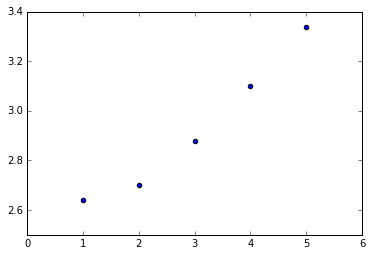

In [13]:
GPA_mean = category_mean(train)
print(GPA_mean)
Categories = np.array([1,2,3,4,5])
plt.scatter(Categories, GPA_mean)
plt.show()

Could you see the trend? It tells us that our intuition is correct. We now seek a linear regression model using this training data and see if we can use this model to predict the mean GPA of the test data.

There are numerous ways to do linear regression in Python. Here we show three of them, using package `numpy.polyfit`, `scipy.stats.linregress` and `sklearn.linear_model.LinearRegression`.

**Let's do linear regression with `numpy.polyfit`** You can learn about this function at <https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html>


slope : 0.1789273631563654
intercept : 2.395559776347926
mean square error : 0.0024238466156115664


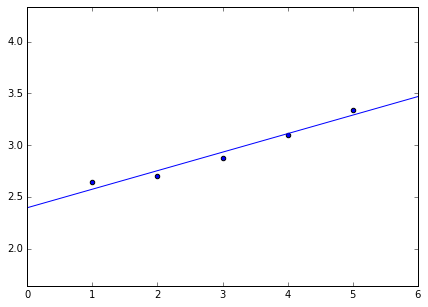

In [14]:
# the argument "1" tells polyfit we are doing an linear regression (linear is degree 1)
coef = np.polyfit(Categories,GPA_mean,1)
print('slope : {}'.format(coef[0]))
print('intercept : {}'.format(coef[1]))
    
# we plot the regression line along with the data points
helper.scatterplot_with_line(Categories, GPA_mean, coef[0], coef[1])

# calculate mean square error
mse = np.mean(((coef[0]*Categories + coef[1] - GPA_mean) ** 2))
print('mean square error : {}'.format(mse))

2.1 Evaluation and Generalization

**Next we are gonna use the slope and intercept to predict the average GPA for the test data and calculate the mean square error**

mean square error of prediction: 0.020516604082810835


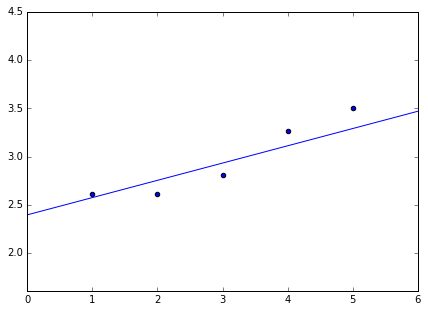

In [15]:
GPA_mean_predict = coef[0]*Categories + coef[1]
GPA_mean_test = category_mean(test)
helper.scatterplot_with_line(Categories, GPA_mean_test, coef[0], coef[1])
mse_test = np.mean(((GPA_mean_predict - GPA_mean_test) ** 2))
print('mean square error of prediction: {}'.format(mse_test))

You can also do linear regression to predict mean GPA with science and social skills (`t5c13b`) and math skills (`t5c13c`) respectively.

Next, we do linear regression based on the original training data. In other words, we directly predict GPA instead of mean GPA. Fisrt, fit the model to traning data

In [16]:
X_train, y_train = train['t5c13a'], train['gpa']
X_train.head()

challengeID
1564    4
700     4
1223    1
3386    3
377     3
Name: t5c13a, dtype: int64

mean square error : 0.3928032744536407


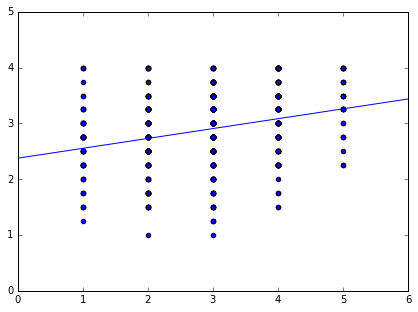

In [17]:
from sklearn import linear_model
#X_train_M = np.expand_dims(train['t5c13a'], axis=1)
X_train, y_train = train['t5c13a'], train['gpa']
X_train = np.expand_dims(X_train, axis=1)
y_train = np.expand_dims(y_train, axis=1)

# fit the linear regression model and get the slope and intercept
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

slope = reg.coef_[0]
intercept = reg.intercept_

# we plot the regression line along with the data points
helper.scatterplot_with_line(X_train, y_train, slope, intercept)

# calculate mean square error
mse = np.mean(((slope*X_train + intercept - y_train) ** 2))
print('mean square error : {}'.format(mse))

Then, use the model to predict GPA for test data

mean square error of prediction: 0.45550712243196134


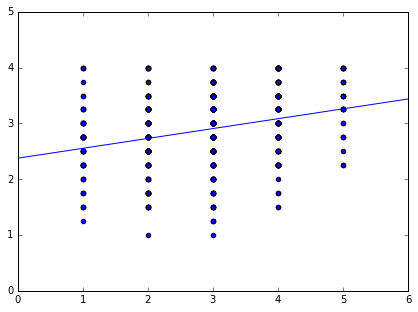

In [18]:
X_test, y_test = test['t5c13a'], test['gpa']
X_test = np.expand_dims(X_test, axis=1)
y_test = np.expand_dims(y_test, axis=1)

y_predict = reg.predict(X_test)

helper.scatterplot_with_line(X_train, y_train, slope, intercept)

mse_test = np.mean(((y_predict - y_test) ** 2))
print('mean square error of prediction: {}'.format(mse_test))

# 2. Multivariate Linear Regression
2 predictors - plot in 3D

can add more but it's hard to visualize.

## Multiple Linear Regression

Multiple linear regression is a generalization of linear regression. In multiple linear regression we model the relationship between a continuous variable (called the outcome or the dependent variable) and multiple explanatory variables (called predictors or independent variables). 

As in linear regression, we plot the data on a scatter plot and then compute the best-fit line through the data points. However, we use a different equation for the best-fit line which takes into account the effects of multiple predictors $X_1,X_2,\dots,X_n$: 

The best-fit line is described by the equation:

$$Y = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \dots + c_n X_n + \epsilon$$

where $c_0$ is the regression coefficient associated with the value of $Y$ when $X=0$, and $c_i$ where $i = 1,2,3,\dots,n$ is the regression coefficient that tells us by how much $Y$ changes when the predictor $X_i$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit line provides what is known as a linear model which allows us to make predictions about the value of $Y$ given the values of $X_i$.

In this section we will build a multiple linear regression model to predict the child's GPA scores. As predictors, we will use language and literacy skills (feature t5c13a), science and social skills (feature t5c13b), and math skills (feature t5c13c).

In [19]:
#Remember our dataframe X and GPA
edu_nonan.head()

,t5c13a,t5c13b,t5c13c,gpa
challengeID,,,,
9,1,2,2,2.25
14,3,4,4,3.25
16,1,2,2,2.00
18,2,2,2,2.25
23,2,4,3,2.50


Let's reshuffle the data

In [20]:
# Split our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(edu_nonan.iloc[:,:3], edu_nonan.gpa, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(513, 3)
(221, 3)


In this section, we'll again use `sklearn.linear_model.LinearRegression` to do multiple linear regression.

In [21]:
# fit the linear regression model and get the slope and intercept
reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We denote $X_1$, $X_2$, $X_3$ as three features `t5c13a`, `t5c13b`, `t5c13c`, respectively. Then the multiple regression model can be written as 

$Y = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \epsilon$

The coefficients can be retrieved from the fitted model.


In [22]:
print('[c_1 c_2 c_3] = {}'.format(reg.coef_))
print('c_0 = {}'.format(reg.intercept_))

[c_1 c_2 c_3] = [ 0.07342398  0.07174348  0.07980745]
c_0 = 2.232323274548894


We can use this model to predict the GPA for students in the test set.

In [23]:
y_predict = reg.predict(X_test)

# calculate mean square error
mse_test = np.mean(((y_predict - y_test) ** 2))
print('mean square error of prediction : {}'.format(mse_test))

mean square error of prediction : 0.4480834881179986


In [24]:
slope = reg.coef_
intercept = reg.intercept_

In [29]:
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)